In [ ]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import yfinance as yf

Financial Reverse Engineering

In [ ]:
symbols = [
    "^DJI",
    "^GSPC"
]

START = "2024-11-05"
END = None

signal = yf.download(symbols,  start=START, end=END)["Close"].dropna()

DJIA = signal[symbols[0]]

SP500 = signal[symbols[-1]]

def correlation(m, n):
  return np.corrcoef(m, n)[0][1]

/tmp/ipython-input-3211076637.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  signal = yf.download(symbols,  start=START, end=END)["Close"].dropna()
[*********************100%***********************]  2 of 2 completed


In [ ]:
signal

Ticker,^DJI,^GSPC
Date,,
2024-11-05,42221.878906,5782.759766
2024-11-06,43729.929688,5929.040039
2024-11-07,43729.339844,5973.100098
2024-11-08,43988.988281,5995.540039
2024-11-11,44293.128906,6001.350098
...,...,...
2025-11-14,47147.480469,6734.109863
2025-11-17,46590.238281,6672.410156
2025-11-18,46091.738281,6617.319824


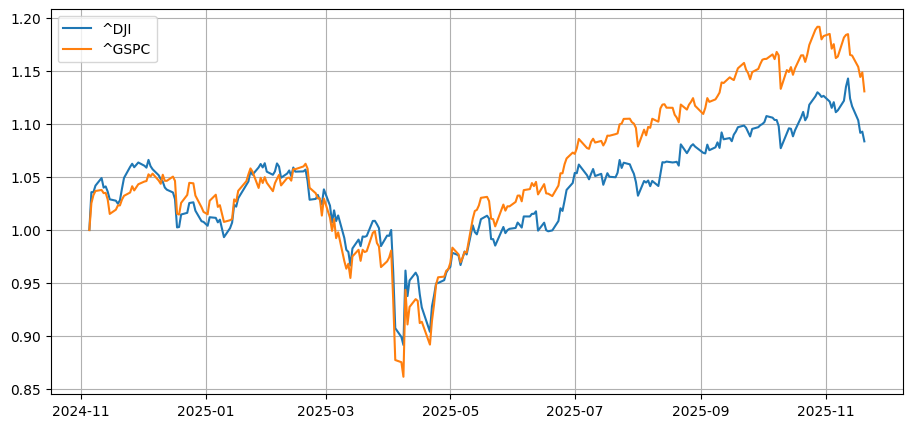

In [ ]:
plt.figure(figsize=(11, 5))
plt.plot(signal / signal.iloc[0], label=signal.columns)
plt.legend()
plt.grid()
plt.show()

In [ ]:
M = 21

CDS = dict(zip(range(1, M + 1), [None] * (M + 1)))
CSD = dict(zip(range(1, M + 1), [None] * (M + 1)))

for m in CSD.keys():
  spread_days = np.linspace(5 * m, 5 * (m + 1), 6).astype(int)
  window_days = spread_days.copy()

  CDS[m] = []
  CSD[m] = []
  for i in range(signal.shape[0]):
    for spread in spread_days:
      if 2 * (i + spread) >= DJIA.shape[0] + SP500.shape[0]:
        break

      for w in window_days:
        x, y, q, z = (
            np.array(DJIA.iloc[i: i + w]),
            np.array(SP500.iloc[i: i + w]),
            np.array(DJIA.iloc[i + spread: i + spread + w]),
            np.array(SP500.iloc[i + spread: i + spread + w]),
        )

        if w > spread:
          break

        if len(x) + len(y) + len(z) + len(q) != 4 * w:
          break

        c_ = correlation(x, z)
        CDS[m].append(c_)

        c_ = correlation(y, q)
        CSD[m].append(c_)

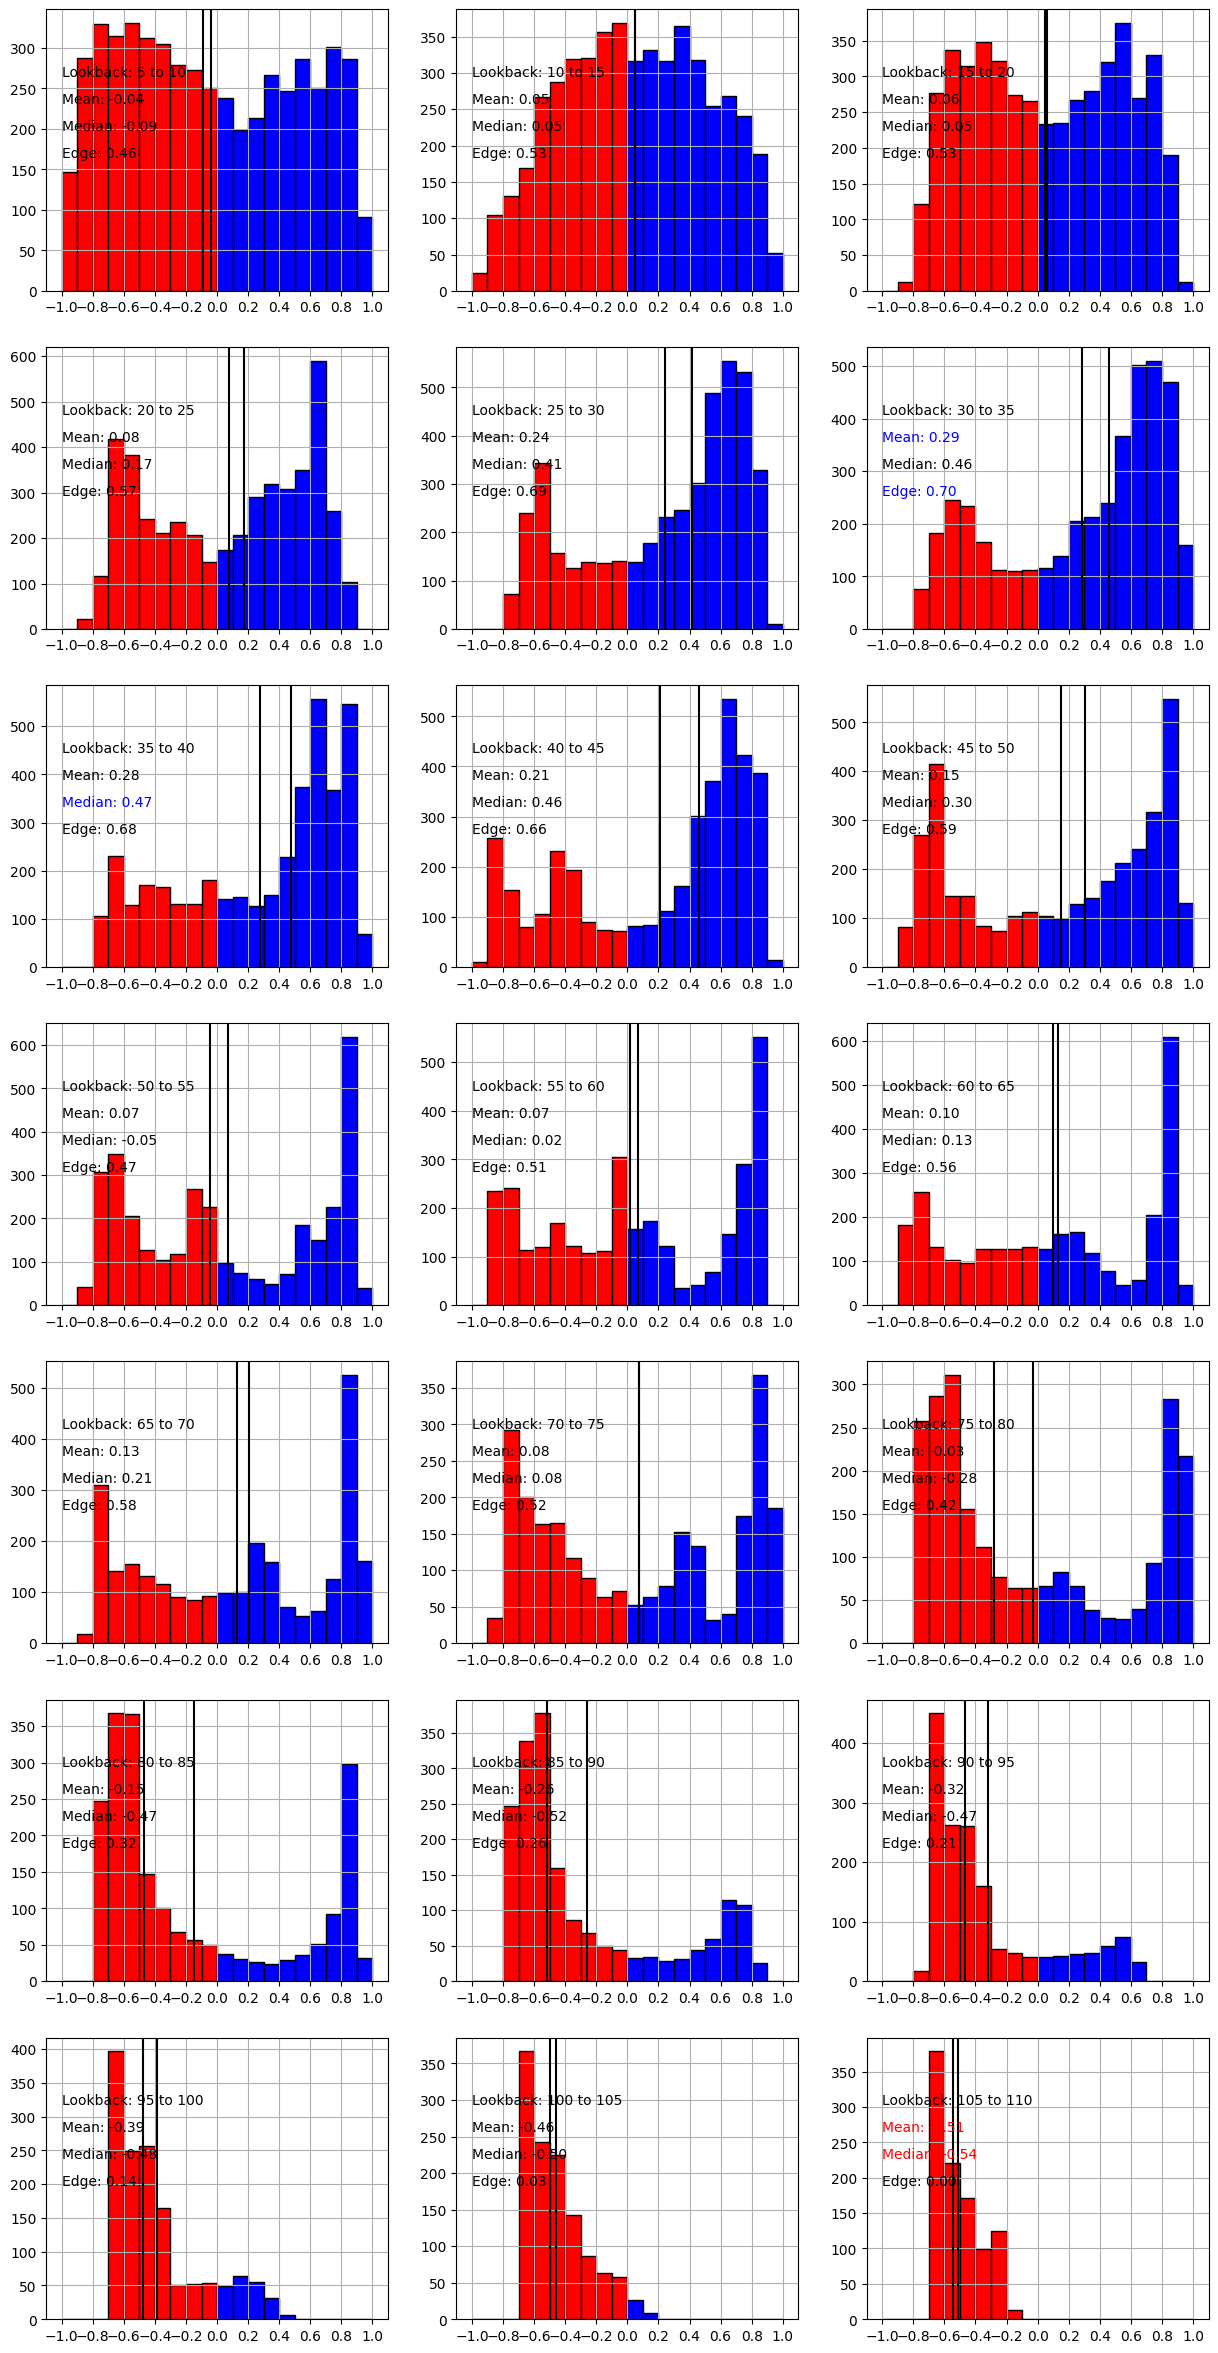

In [ ]:
fig, axes = plt.subplots(7, 3, figsize=(15, 30))
medians = [np.median(CSD[k]) for k in CSD]
means = [np.mean(CSD[k]) for k in CSD]
edges = [(np.array(CSD[k]) > 0).sum() / len(CSD[k]) for k in CSD]
edge_min, edge_max = np.max(edges), np.max(edges)
median_min, median_max = np.min(medians), np.max(medians)
mean_min, mean_max = np.min(means), np.max(means)
for i in range(7):
  for j in range(3):
    k = i * 3 + j + 1
    # bins = np.linspace(0, min(10, np.max(C[k]) * 1.01), 11)
    bins = np.linspace(-1, 1, 21)
    x, y, z = axes[i][j].hist(CSD[k], bins=bins, edgecolor='black')
    for l in range(len(z)):
      if l < len(z) // 2:
        z[l].set_facecolor("r")
      else:
        z[l].set_facecolor("b")

    c_mean = "b" if means[k - 1] == mean_max else ("r" if means[k - 1] == mean_min else "k")
    c_median = "b" if medians[k - 1] == median_max else ("r" if medians[k - 1] == median_min else "k")
    c_edge = "b" if edges[k - 1] == edge_max else ("r" if edges[k - 1] == edge_min else "k")

    axes[i][j].axvline(np.median(CSD[k]), color="k")
    axes[i][j].axvline(np.mean(CSD[k]), color="k")
    axes[i][j].text(bins[0], 0.8 * x.max(), f"Lookback: {5 * k} to {5 * (k + 1)}")
    axes[i][j].text(bins[0], 0.5 * x.max(), f"Edge: {edges[k - 1]:.2f}", color=c_edge)
    axes[i][j].text(bins[0], 0.7 * x.max(), f"Mean: {means[k - 1]:.2f}", color=c_mean)
    axes[i][j].text(bins[0], 0.6 * x.max(), f"Median: {medians[k - 1]:.2f}", color=c_median)
    axes[i][j].set_xticks(bins[::2])
    axes[i][j].grid()
plt.show()

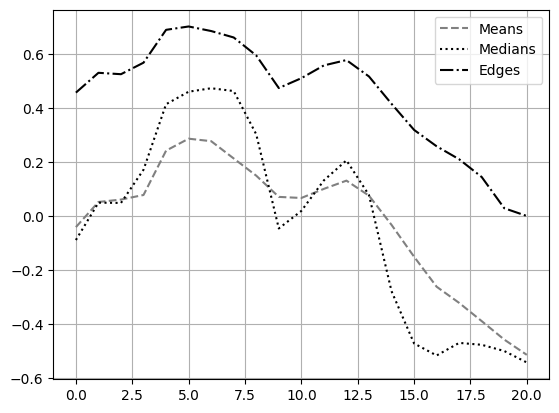

In [ ]:
plt.plot(means, "--", color='gray', label="Means")
plt.plot(medians, ":", color="black", label="Medians")
plt.plot(edges, "-.", color="black", label="Edges")
plt.grid()
plt.legend()
plt.show()

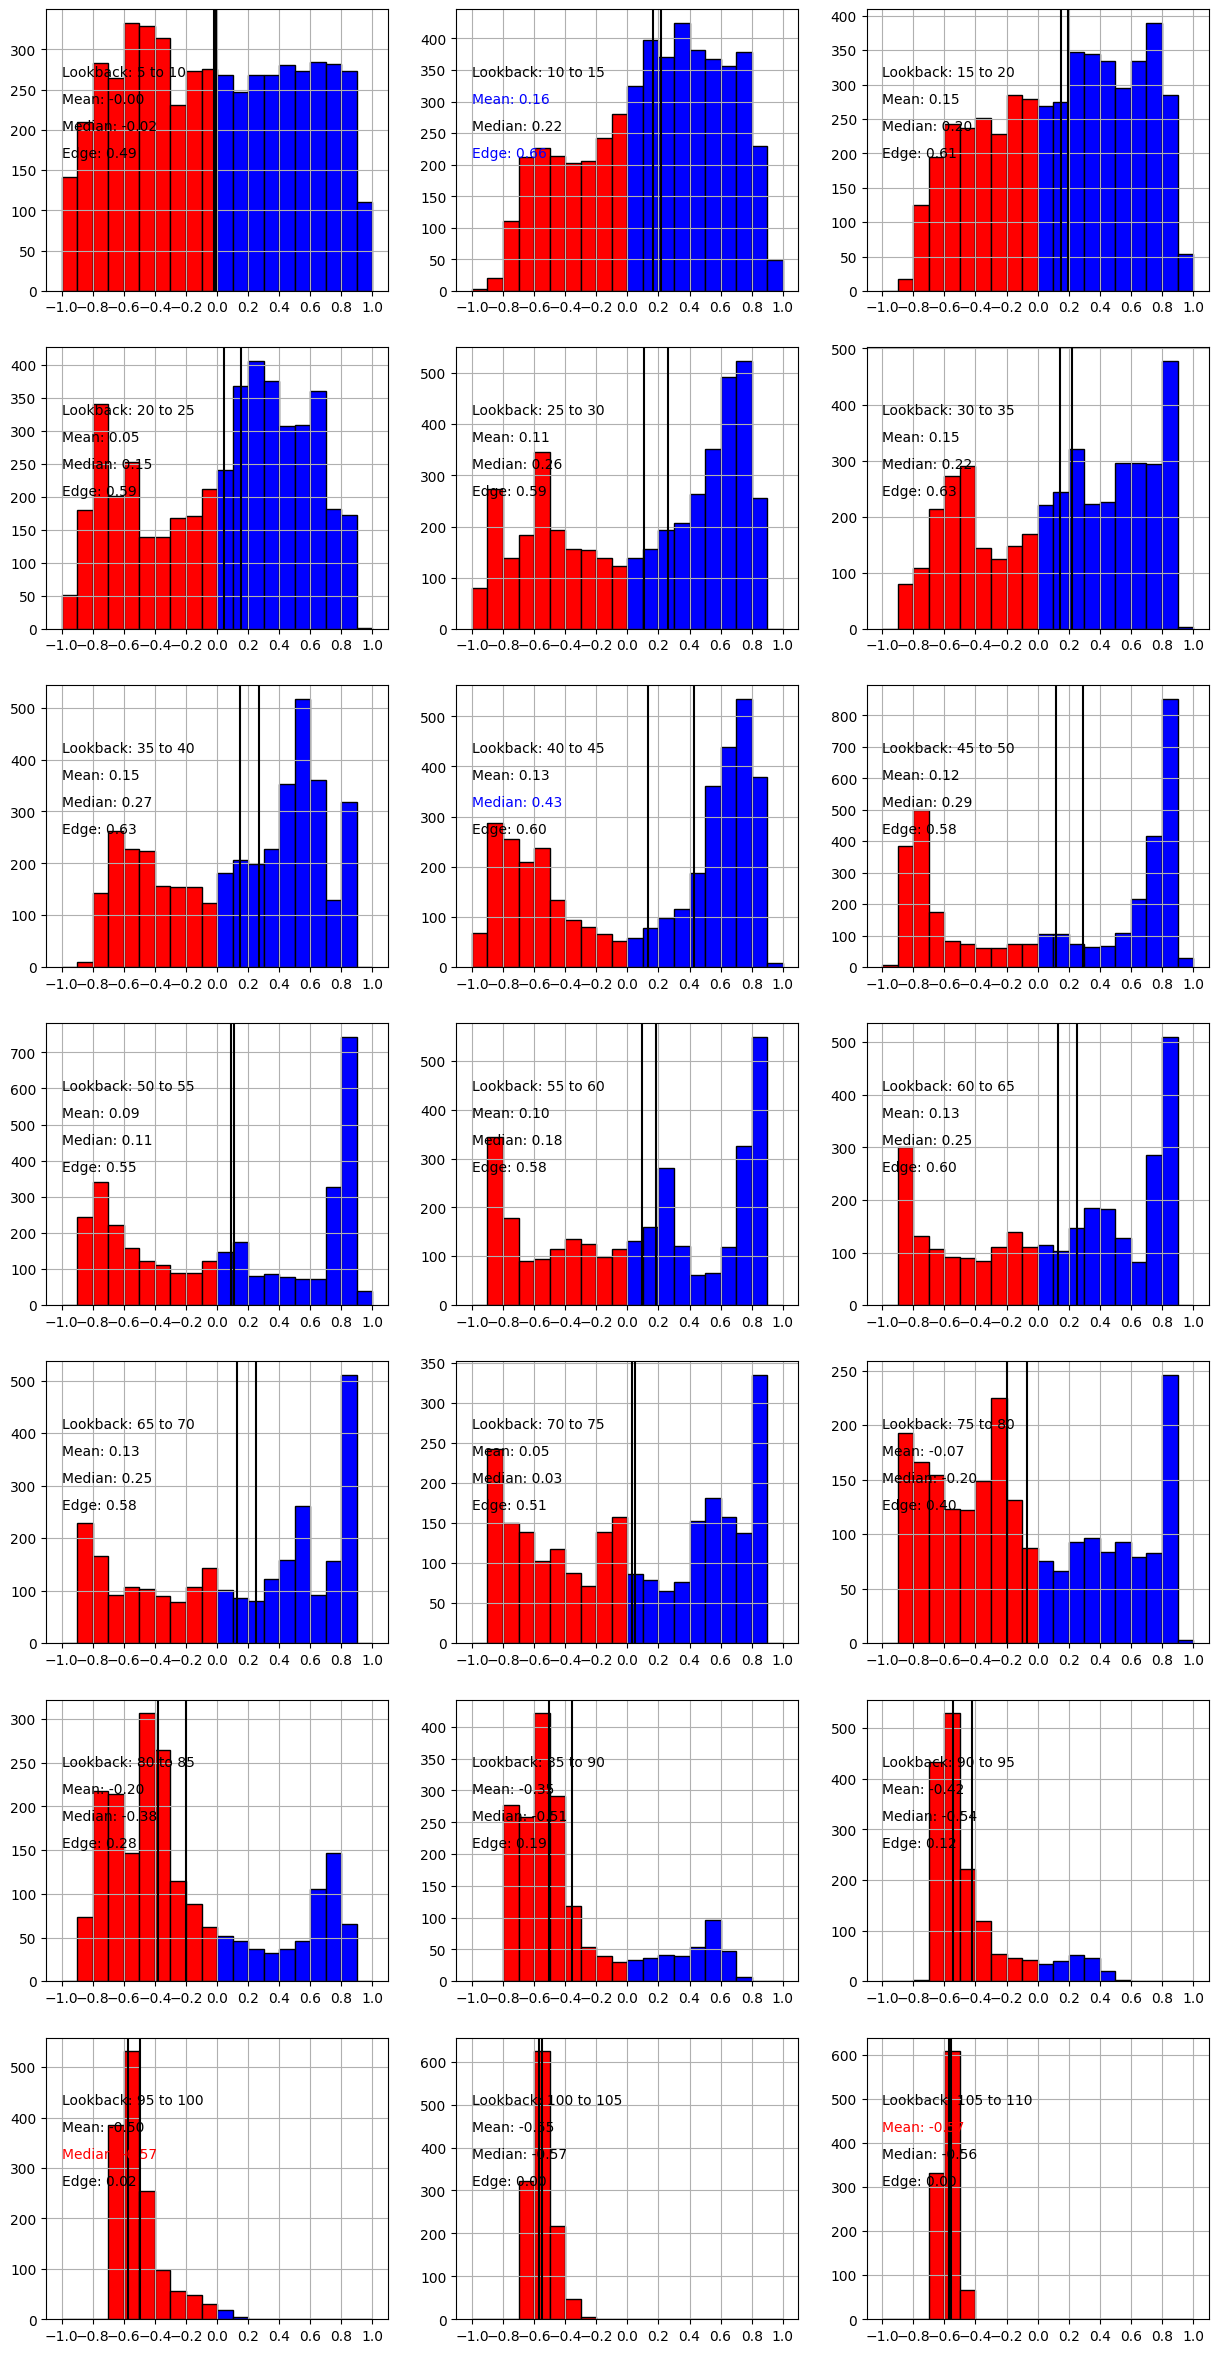

In [ ]:
fig, axes = plt.subplots(7, 3, figsize=(15, 30))
medians = [np.median(CDS[k]) for k in CSD]
means = [np.mean(CDS[k]) for k in CSD]
edges = [(np.array(CDS[k]) > 0).sum() / len(CDS[k]) for k in CDS]
edge_min, edge_max = np.max(edges), np.max(edges)
median_min, median_max = np.min(medians), np.max(medians)
mean_min, mean_max = np.min(means), np.max(means)
for i in range(7):
  for j in range(3):
    k = i * 3 + j + 1
    # bins = np.linspace(0, min(10, np.max(C[k]) * 1.01), 11)
    bins = np.linspace(-1, 1, 21)
    x, y, z = axes[i][j].hist(CDS[k], bins=bins, edgecolor='black')
    for l in range(len(z)):
      if l < len(z) // 2:
        z[l].set_facecolor("r")
      else:
        z[l].set_facecolor("b")

    c_mean = "b" if means[k - 1] == mean_max else ("r" if means[k - 1] == mean_min else "k")
    c_median = "b" if medians[k - 1] == median_max else ("r" if medians[k - 1] == median_min else "k")
    c_edge = "b" if edges[k - 1] == edge_max else ("r" if edges[k - 1] == edge_min else "k")

    axes[i][j].axvline(np.median(CDS[k]), color="k")
    axes[i][j].axvline(np.mean(CDS[k]), color="k")
    axes[i][j].text(bins[0], 0.8 * x.max(), f"Lookback: {5 * k} to {5 * (k + 1)}")
    axes[i][j].text(bins[0], 0.5 * x.max(), f"Edge: {edges[k - 1]:.2f}", color=c_edge)
    axes[i][j].text(bins[0], 0.7 * x.max(), f"Mean: {means[k - 1]:.2f}", color=c_mean)
    axes[i][j].text(bins[0], 0.6 * x.max(), f"Median: {medians[k - 1]:.2f}", color=c_median)
    axes[i][j].set_xticks(bins[::2])
    axes[i][j].grid()
plt.show()


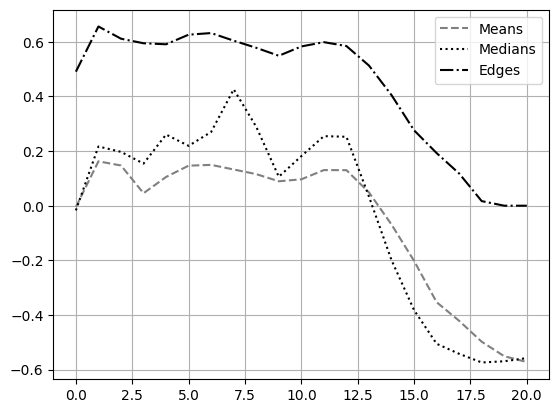

In [ ]:
plt.plot(means, "--", color='gray', label="Means")
plt.plot(medians, ":", color="black", label="Medians")
plt.plot(edges, "-.", color="black", label="Edges")
plt.grid()
plt.legend()
plt.show()